# Coffee Shop Site Selection in Paris


The objective of this notebook is to provide Paris city clustering that can help to choose at which neighborhood is better to open a coffee shop.

The criteria used to select a site are the following:
- Median household income: target high income households
- Population density: dense neighborhoods would have more potential customers
- Employee base: neighborhoods with more offices and industrial sites would have more potential customers.
- Employment status: neighborhoods with high employment rate are preferred
- Competitors: neighborhoods with less competitors are preferred

The criteria list is non-exhaustive. I choose only the above criteria due to the lack of data.
For instance, it is possible to include vehicle traffic in the neighborhood.

<h1>Table of contents</h1>

<div class="alert alert-block alert-info" style="margin-top: 20px">
    <ol>
        <li><a href="#ref1">Data</a></li>
        <li><a href="#ref2">Acquiring the Data</a></li>
        <li><a href="#ref3">Exploring and Preprocessing Data</a></li>
        <li><a href="#ref4">Cluster Paris Neighborhoods</a></li>
        <li><a href="#ref5">Examine Clusters</a></li>
        <li><a href="#ref6">Conclusion</a></li>
    </ol>
</div>
<br>
<hr>

Before we get the data, let's download all the dependencies that we will need.

In [2]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import geocoder

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

# import k-means from clustering stage
from sklearn.cluster import KMeans

from sklearn.preprocessing import StandardScaler

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

#import library for web scraping
from bs4 import BeautifulSoup 

 #library used to handle url
import urllib

#library for styling maps
from branca.colormap import linear

#library for string coding
import unicodedata

print('Libraries imported.')

Libraries imported.




<a id="ref1"></a>
# 1. Data

To build the neighborhood dataframe, I downloaded two jeson files from https://www.data.gouv.fr/ website: **arrondissements-paris.json**,  **quartier_paris.json**. 
1. arrondissements-paris.json: this file includes all data about Paris boroughs (postal code, name, center coordinates, border coordinates)
2. quartier_paris.json: this file includes all data about Paris neighborhoods (borough, name, center coordinates, border coordinates)

I used Foursquare API to get the most common venues of each neighborhood of Paris. This data allows to look to competitors and avoid to be close to other coffee shops.

To conduct this study, I used data on INSEE website which is the national institute of statistics and studies of economics in France. On INSEE website, https://www.insee.fr/, I found information about median household income, population density, and employment status for each borough from the 20 boroughs which compose Paris. The data is on table format and it is necessary to use scraping techniques to produce clean datasets.

INSEE gives, as well, data about type of establishments at each borough. This information is useful to determine whether a neighborhood can be considered as an employee base.




<a id="ref2"></a>
# 2. Acquiring Data

 The json files, _arrondissements-paris.json_ and _quartier_paris.json_, use the same keys which becomes easier to extract the requestetd data. 
- the key 'c_ar' gives the borough number which is added to 75000 to get the postal code of each borough.
- the key 'l_aroff' gives the borough name
- the key 'l_qu' gives the neighborhood name
- the key 'geom_x_y' gives latitude and longitude of the neighborhood center
- the key 'surface' will be used to get borough surface which will be used later on demographic data


In [3]:
#initialize an empty list
neighborhood_list=[]

#open the json files
with open('quartier_paris.json','r') as f_neigh, open('arrondissements-paris.json','r') as f_bor:
    neigh_dict=json.load(f_neigh)
    bor_dict=json.load(f_bor)
    
    #extract neighborhood data
    for neigh in neigh_dict['features']:
        borough=[bor['properties']['l_aroff'] for bor in bor_dict['features'] if bor['properties']['c_ar']==neigh['properties']['c_ar']][0]
        borough_surf=[bor['properties']['surface'] for bor in bor_dict['features'] if bor['properties']['c_ar']==neigh['properties']['c_ar']][0]
        neighborhood_list.append([75000+neigh['properties']['c_ar'],borough,borough_surf,neigh['properties']['l_qu'], neigh['properties']['geom_x_y'][0], neigh['properties']['geom_x_y'][1] ])

#create neighborhood dataframe
Paris_Neighborhoods=pd.DataFrame(neighborhood_list,columns=['PostalCode', 'Borough', 'Borough Surface', 'Neighborhood', 'Latitude', 'Longitude'])

In [4]:
Paris_Neighborhoods.head()

,PostalCode,Borough,Borough Surface,Neighborhood,Latitude,Longitude
0,75004,Hôtel-de-Ville,1.600586e+06,Arsenal,48.851585,2.364768
1,75005,Panthéon,2.539375e+06,Jardin-des-Plantes,48.841940,2.356894
2,75010,Entrepôt,2.891739e+06,Porte-Saint-Martin,48.871245,2.361504
3,75011,Popincourt,3.665442e+06,Roquette,48.857064,2.380364
4,75012,Reuilly,1.631478e+07,Picpus,48.830359,2.428827


Let's use Foursquare APIs to get Paris venues.

Let's start by defining Foursquare credentials and version

In [5]:
CLIENT_ID = '****' # your Foursquare ID
CLIENT_SECRET = '*****' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET: ' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: SPADJOIC3UFDNMTOSEUF204GFY5X35QWSMJ0EDHWCFDAONDK
CLIENT_SECRET: MGY1RAQ43WVXFCXMFU0XKKQAOVTDGBIY1XVMVQGF1P31HUA5


Let's define a function, **getNearbyVenues**, which can get all venues of a list of neighborhoods by given their coordinates.

In [6]:
def getNearbyVenues(names, latitudes, longitudes, radius=500, LIMIT=1000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'],
            v['venue']['id'],
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue',
                  'Venue id',
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Use the function **getNearbyVenues** to get Paris venues.

In [7]:
Paris_venues = getNearbyVenues(names=Paris_Neighborhoods['Neighborhood'],
                                   latitudes=Paris_Neighborhoods['Latitude'],
                                   longitudes=Paris_Neighborhoods['Longitude']
                                  )

Arsenal
Jardin-des-Plantes
Porte-Saint-Martin
Roquette
Picpus
Plaisance
Monnaie
Odéon
Champs-Elysées
Maison-Blanche
Croulebarbe
Saint-Merri
Notre-Dame
Gros-Caillou
Batignolles
Europe
Sainte-Marguerite
Parc-de-Montsouris
Saint-Lambert
Vivienne
Enfants-Rouges
Saint-Germain-des-Prés
Saint-Vincent-de-Paul
Saint-Ambroise
Bel-Air
Montparnasse
Plaine de Monceaux
Sainte-Avoie
Hôpital-Saint-Louis
Belleville
Ternes
Arts-et-Métiers
Archives
Faubourg-du-Roule
Rochechouart
Bercy
Halles
Folie-Méricourt
Salpêtrière
Place-Vendôme
Combat
Charonne
Javel
Val-de-Grâce
Necker
Père-Lachaise
La Chapelle
Saint-Victor
Madeleine
Saint-Fargeau
Porte-Dauphine
Grandes-Carrières
Ecole-Militaire
Grenelle
Auteuil
Quinze-Vingts
Sorbonne
Saint-Georges
Chaussée-d'Antin
Palais-Royal
Saint-Gervais
Saint-Thomas-d'Aquin
Porte-Saint-Denis
Saint-Germain-l'Auxerrois
Villette
Notre-Dame-des-Champs
Petit-Montrouge
Pont-de-Flandre
Muette
Chaillot
Epinettes
Mail
Bonne-Nouvelle
Gare
Clignancourt
Goutte-d'Or
Invalides
Faubourg-Montm

In [8]:
#drop duplicate venues based on venue id column
Paris_venues.drop_duplicates(subset=['Venue id'], inplace=True)

In [10]:
Paris_venues.drop(columns=['Venue id'],axis=1).head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Arsenal,48.851585,2.364768,Sherry Butt,48.853267,2.364114,Cocktail Bar
1,Arsenal,48.851585,2.364768,Maria Loca,48.852123,2.365667,Cocktail Bar
2,Arsenal,48.851585,2.364768,Café Ginger,48.852887,2.367354,Vegetarian / Vegan Restaurant
3,Arsenal,48.851585,2.364768,Pavillon de l'Arsenal,48.850650,2.362340,Museum
4,Arsenal,48.851585,2.364768,Keep Cool,48.852085,2.363371,Gym


Let's check the size of the result and find out how many unique categories can be curated from all the returned venues

In [11]:
print('Result size:',Paris_venues.shape) 
print('There are {} uniques categories.'.format(len(Paris_venues['Venue Category'].unique())))

Result size: (4107, 8)
There are 293 uniques categories.


Now that we built neighborhood dataframe, we will focus on getting the following data from https://www.insee.fr: 
- Median household income
- Population density
- Employee base
- Employment status

INSEE website provides data per borough. Therefore, I will scrape data for each borough and then assign the values to the neighborhoods composing it.

In [21]:
#create borough dataframe
Paris_Boroughs=Paris_Neighborhoods[['PostalCode','Borough', 'Borough Surface']].drop_duplicates().reset_index(drop=True)
Paris_Boroughs.head()

,PostalCode,Borough,Borough Surface
0,75004,Hôtel-de-Ville,1.600586e+06
1,75005,Panthéon,2.539375e+06
2,75010,Entrepôt,2.891739e+06
3,75011,Popincourt,3.665442e+06
4,75012,Reuilly,1.631478e+07


In [13]:
borough_info_list=[]
for bor in Paris_Boroughs['PostalCode']:
    print('Borough: ', bor)
    #INSEE code = postal code + 100
    INSEE_CODE=bor+100

    #define link to the INSEE page
    borough_page = urllib.request.urlopen("https://www.insee.fr/fr/statistiques/2011101?geo=COM-"+str(INSEE_CODE))

    #define BeautifulSoup object
    borough_soup = BeautifulSoup(borough_page) 

    #get borough population density 
    borough_density=float(unicodedata.normalize('NFKC',borough_soup.main.section.find("table", {"id": "produit-tableau-POP_T1"}).findAll('tr')[2].findAll('td')[7].text).replace(' ','').replace(',','.'))

    #get median household income
    borough_hshd_inocome=float(unicodedata.normalize('NFKC',borough_soup.main.section.find("table", {"id": "produit-tableau-REV_T1"}).findAll('tr')[3].findAll('td')[0].text).replace(' ',''))

    #get unemployment rate
    borough_unemployment=float(unicodedata.normalize('NFKC',borough_soup.main.section.find("table", {"id": "produit-tableau-EMP_T1"}).findAll('tr')[4].findAll('td')[0].text).replace(' ','').replace(',','.'))

    #get employee number in commerce, administrative, health, industry ... sectors
    borough_employee_base=int(unicodedata.normalize('NFKC',borough_soup.main.section.find("table", {"id": "produit-tableau-CEN_T2"}).findAll('tr')[5].findAll('td')[0].text).replace(' ','').replace(',','.'))\
    +int(unicodedata.normalize('NFKC',borough_soup.main.section.find("table", {"id": "produit-tableau-CEN_T2"}).findAll('tr')[7].findAll('td')[0].text).replace(' ','').replace(',','.'))\
    +int(unicodedata.normalize('NFKC',borough_soup.main.section.find("table", {"id": "produit-tableau-CEN_T2"}).findAll('tr')[3].findAll('td')[0].text).replace(' ','').replace(',','.'))

    borough_info_list.append([borough_density, borough_hshd_inocome, borough_unemployment, borough_employee_base])


Borough:  75004
Borough:  75005
Borough:  75010
Borough:  75011
Borough:  75012
Borough:  75014
Borough:  75006
Borough:  75008
Borough:  75013
Borough:  75007
Borough:  75017
Borough:  75015
Borough:  75002
Borough:  75003
Borough:  75020
Borough:  75009
Borough:  75001
Borough:  75019
Borough:  75018
Borough:  75016


In [22]:
Paris_Boroughs_Info=pd.DataFrame(borough_info_list,columns=['Population Density','Median Household Income', 'Unemployment Rate', 'Preferred Sector Employees' ])
Paris_Boroughs=pd.concat([Paris_Boroughs, Paris_Boroughs_Info], axis=1)
Paris_Boroughs.head()

,PostalCode,Borough,Borough Surface,Population Density,Median Household Income,Unemployment Rate,Preferred Sector Employees
0,75004,Hôtel-de-Ville,1.600586e+06,17179.4,31007.0,8.3,59941
1,75005,Panthéon,2.539375e+06,23270.9,33169.0,7.0,52128
2,75010,Entrepôt,2.891739e+06,31810.4,25618.0,9.9,77325
3,75011,Popincourt,3.665442e+06,40059.1,26810.0,9.8,57000
4,75012,Reuilly,1.631478e+07,8670.0,27110.0,8.5,109422




<a id="ref3"></a>
# 3. Exploring and Preprocessing Data

The map below, created using folium, displays a general view of Paris including boroughs and neighborhoods. We can easily distinguish the different boroughs and the **four neighborhoods** composing each borough.

In [79]:
# define Downtown address
address = 'Paris, France'

#get Paris location
geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

#load geomjson files of Paris
Paris_Borough_geo=f'arrondissements-paris.json'
Paris_Neigh_geo=f'quartier_paris.json'

# create map
map_neigh = folium.Map(location=[latitude, longitude], zoom_start=12)

#set color scheme and styling for Boroughs
x = np.arange(len(Paris_Neighborhoods['Borough'].value_counts()))
ys = [i + x + (i*x)**2 for i in range(len(Paris_Neighborhoods['Borough'].value_counts()))]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

style_function_borough=lambda x: {
    'fillColor': rainbow[(x['properties']['c_ar'])-1],
    'color': 'black',
    'weight': 2.5,
    'fillOpacity': 0.7
}

#set color scheme and styling for Neighborhoods
style_function_nbh=lambda x: {
    'fillColor': rainbow[0],
    'color': 'black',
    'weight': 0.5,
    'fillOpacity': 0
}

#add boroughs
folium.GeoJson(
    Paris_Borough_geo,
    style_function=style_function_borough,
    name='geojson',
).add_to(map_neigh)

#add neighborhoods
folium.GeoJson(
    Paris_Neigh_geo,
    style_function=style_function_nbh,
    name='geojson',
).add_to(map_neigh)

# display map
map_neigh

As we are interested only by coffee shops, we need to extract from **Paris_venues** dataframe those shops based on the category column. Coffee shops belong to the categories _Café_ or _Coffee Shop_.  The new dataframe will be **Paris_cafes**.

In [16]:
Paris_cafes=Paris_venues[Paris_venues['Venue Category'].isin(['Café','Coffee Shop'])]
Paris_cafes.reset_index(inplace=True, drop=True)
Paris_cafes.drop(columns=['Venue id'], axis=1).head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Arsenal,48.851585,2.364768,Yellow Tucan,48.854684,2.367288,Coffee Shop
1,Arsenal,48.851585,2.364768,Chez Oscar,48.854552,2.368805,Café
2,Jardin-des-Plantes,48.841940,2.356894,Extra Life,48.841158,2.350184,Café
3,Jardin-des-Plantes,48.841940,2.356894,Nuance Café,48.845088,2.354891,Coffee Shop
4,Porte-Saint-Martin,48.871245,2.361504,Hubsy | Café & Coworking,48.871241,2.360203,Coffee Shop


Let's check the distribution of coffee shops at each Neighborhood.

In [17]:
# add borough column to Paris_cafes
borough_list=[Paris_Neighborhoods[Paris_Neighborhoods['Neighborhood']==cs].iloc[0,1] for cs in Paris_cafes['Neighborhood']]
Paris_cafes.insert(0,'Borough',borough_list, True)

In [18]:
Paris_cafes.drop(columns=['Venue id'], axis=1).head()

,Borough,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Hôtel-de-Ville,Arsenal,48.851585,2.364768,Yellow Tucan,48.854684,2.367288,Coffee Shop
1,Hôtel-de-Ville,Arsenal,48.851585,2.364768,Chez Oscar,48.854552,2.368805,Café
2,Panthéon,Jardin-des-Plantes,48.841940,2.356894,Extra Life,48.841158,2.350184,Café
3,Panthéon,Jardin-des-Plantes,48.841940,2.356894,Nuance Café,48.845088,2.354891,Coffee Shop
4,Entrepôt,Porte-Saint-Martin,48.871245,2.361504,Hubsy | Café & Coworking,48.871241,2.360203,Coffee Shop


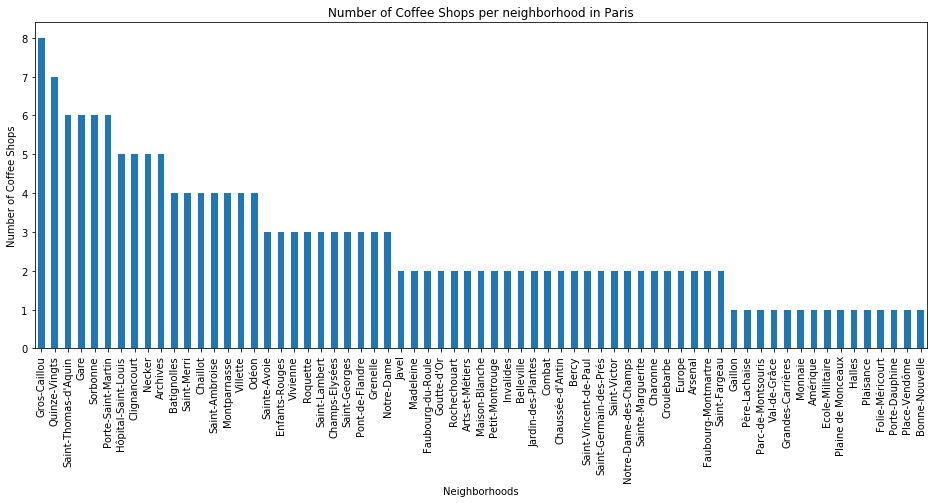

In [23]:
#get data for neighborhoods to plot in bar chart
neigh_cafe_counts=Paris_cafes['Neighborhood'].value_counts()

neigh_cafe_counts.plot(kind='bar', figsize=(16, 6))

plt.xlabel('Neighborhoods') # add to x-label to the plot
plt.ylabel('Number of Coffee Shops') # add y-label to the plot
plt.title('Number of Coffee Shops per neighborhood in Paris') # add title to the plot

plt.show()

Based on the bar chart, number of coffee shops per neighborhood, we can classify neighborhoods in 3 categories.  
- **low competitiveness**: number of coffee shops less than 2
- **medium competitiveness**: number of coffee shops is between 2 and 4
- **high competitiveness**: number of coffee shops greater than 4 

Let's add a new column to **Paris_Neighborhoods** and assign each neighborhood its competitiveness category. I will use **getCompetitiveness** function to get competitiveness category from neighborhood name.

In [24]:
def getCompetitiveness(neigh, data):
    comp=''
    if neigh in data.index:
        if data.loc[neigh]['value_counts']<=2:
            comp='low'
        elif data.loc[neigh]['value_counts']<=4:
            comp='medium'
        else: comp='high'
    else: comp='low'
    return(comp)

In [25]:
#define dataframe with number of coffee shops at each neighborhood
neigh_cafe_counts=Paris_cafes['Neighborhood'].value_counts().to_frame()
neigh_cafe_counts.rename(columns={'Neighborhood': "value_counts"}, inplace=True)
neigh_cafe_counts.head()


,value_counts
Gros-Caillou,8
Quinze-Vingts,7
Saint-Thomas-d'Aquin,6
Gare,6
Sorbonne,6


In [26]:
#add new column competitiveness to Paris_Neighborhoods
comp_list=[getCompetitiveness(neigh=neigh,data=neigh_cafe_counts) for neigh in Paris_Neighborhoods['Neighborhood']]
Paris_Neighborhoods.insert(6,'Competitiveness',comp_list, True)
Paris_Neighborhoods.head()

,PostalCode,Borough,Borough Surface,Neighborhood,Latitude,Longitude,Competitiveness
0,75004,Hôtel-de-Ville,1.600586e+06,Arsenal,48.851585,2.364768,low
1,75005,Panthéon,2.539375e+06,Jardin-des-Plantes,48.841940,2.356894,low
2,75010,Entrepôt,2.891739e+06,Porte-Saint-Martin,48.871245,2.361504,high
3,75011,Popincourt,3.665442e+06,Roquette,48.857064,2.380364,medium
4,75012,Reuilly,1.631478e+07,Picpus,48.830359,2.428827,low


Consider **Paris_boroughs** dataframe, the column _Preferred Sector Employees_ gives the number of employees at each borough. To be able to use this data on neighborhoods, I will calculate the density of this varialble by dividding over the borough surface (km2).

In [27]:
#create new column for each borough 
Paris_Boroughs['Preferred Sector Employee Density']=1000000*Paris_Boroughs['Preferred Sector Employees']/Paris_Boroughs['Borough Surface']
Paris_Boroughs.drop(columns=['Borough Surface','Preferred Sector Employees' ],axis=1,inplace=True)

In [28]:
Paris_Boroughs.head()

,PostalCode,Borough,Population Density,Median Household Income,Unemployment Rate,Preferred Sector Employee Density
0,75004,Hôtel-de-Ville,17179.4,31007.0,8.3,37449.417776
1,75005,Panthéon,23270.9,33169.0,7.0,20527.888848
2,75010,Entrepôt,31810.4,25618.0,9.9,26739.961038
3,75011,Popincourt,40059.1,26810.0,9.8,15550.650361
4,75012,Reuilly,8670.0,27110.0,8.5,6706.923557


Let's add all borough information to the correspondant neighborhoods. 

In [53]:
#merge neighborhood dataframe and borough dataframe on borough name
Paris_Neighborhoods=pd.merge(left=Paris_Neighborhoods[['PostalCode','Borough','Neighborhood','Latitude','Longitude','Competitiveness']],\
              right=Paris_Boroughs[['Borough','Population Density','Median Household Income','Unemployment Rate','Preferred Sector Employee Density' ]],\
             left_on='Borough', right_on='Borough')

Paris_Neighborhoods.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Competitiveness,Population Density,Median Household Income,Unemployment Rate,Preferred Sector Employee Density
0,75004,Hôtel-de-Ville,Arsenal,48.851585,2.364768,low,17179.4,31007.0,8.3,37449.417776
1,75004,Hôtel-de-Ville,Saint-Merri,48.858521,2.351667,medium,17179.4,31007.0,8.3,37449.417776
2,75004,Hôtel-de-Ville,Notre-Dame,48.852896,2.352775,medium,17179.4,31007.0,8.3,37449.417776
3,75004,Hôtel-de-Ville,Saint-Gervais,48.855719,2.358162,low,17179.4,31007.0,8.3,37449.417776
4,75005,Panthéon,Jardin-des-Plantes,48.841940,2.356894,low,23270.9,33169.0,7.0,20527.888848




<a id="ref4"></a>
# 4. Cluster Paris Neighborhoods

In [54]:
# one hot encoding Competitiveness column
Paris_onehot = pd.get_dummies(Paris_Neighborhoods[['Competitiveness']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
Paris_onehot=pd.concat([Paris_Neighborhoods,Paris_onehot],axis=1)

# drop non needed columns
Paris_onehot.drop(columns=['PostalCode','Borough','Latitude','Longitude','Competitiveness'],axis=1,inplace=True)
Paris_onehot.rename(columns={'high':'High Competitiveness','low':'Low Competitiveness', 'medium':'Medium Competitiveness'}, inplace=True)


In [55]:
Paris_onehot.head()

,Neighborhood,Population Density,Median Household Income,Unemployment Rate,Preferred Sector Employee Density,High Competitiveness,Low Competitiveness,Medium Competitiveness
0,Arsenal,17179.4,31007.0,8.3,37449.417776,0,1,0
1,Saint-Merri,17179.4,31007.0,8.3,37449.417776,0,0,1
2,Notre-Dame,17179.4,31007.0,8.3,37449.417776,0,0,1
3,Saint-Gervais,17179.4,31007.0,8.3,37449.417776,0,1,0
4,Jardin-des-Plantes,23270.9,33169.0,7.0,20527.888848,0,1,0


Now, let's use **StandardScaler()** to normalize the dataset.

In [56]:
X = Paris_onehot.values[:,1:]
Paris_clustering = StandardScaler().fit_transform(X)
Paris_clustering[0:10]

array([[-0.6363484 ,  0.11257773, -0.37575297,  0.78301586, -0.37796447,
         0.71374643, -0.51946248],
       [-0.6363484 ,  0.11257773, -0.37575297,  0.78301586, -0.37796447,
        -1.4010578 ,  1.92506684],
       [-0.6363484 ,  0.11257773, -0.37575297,  0.78301586, -0.37796447,
        -1.4010578 ,  1.92506684],
       [-0.6363484 ,  0.11257773, -0.37575297,  0.78301586, -0.37796447,
         0.71374643, -0.51946248],
       [ 0.03981028,  0.45596522, -1.21795791, -0.19148048, -0.37796447,
         0.71374643, -0.51946248],
       [ 0.03981028,  0.45596522, -1.21795791, -0.19148048, -0.37796447,
         0.71374643, -0.51946248],
       [ 0.03981028,  0.45596522, -1.21795791, -0.19148048, -0.37796447,
         0.71374643, -0.51946248],
       [ 0.03981028,  0.45596522, -1.21795791, -0.19148048,  2.64575131,
        -1.4010578 , -0.51946248],
       [ 0.98769783, -0.74334973,  0.66080695,  0.16626743,  2.64575131,
        -1.4010578 , -0.51946248],
       [ 0.98769783, -0.7433

I will use **k-means** algorithm to cluster the final dataset. I will use the **elbow point** mehtod to determine the best k value by running the alogorithm over 8 values from 1 to 8.

In [57]:
#define array of k values to be test
k_values=range(1,9)

#create array to stock the mean distance for each k value
k_mean_distances=np.empty(len(k_values))

#run algorithm through k_values array
for k_index, k_value in enumerate(k_values):

    # run k-means clustering
    kmeans = KMeans(init = "k-means++", n_clusters = k_value, n_init = 12).fit(Paris_clustering)

    # check cluster labels generated for each row in the dataframe
    kmeans_labels=kmeans.labels_ 
    kmeans_cluster_centers=kmeans.cluster_centers_
    
    #calculate the mean of distances of each cluster to its points
    cluster_distances=np.empty(k_value)
    for cluster in range(k_value):
        distances=[np.linalg.norm(x-kmeans_cluster_centers[cluster]) for x in Paris_clustering[kmeans_labels==cluster]]
        cluster_distances[cluster]=np.mean(distances)
        
    k_mean_distances[k_index]=cluster_distances.mean()

    

Let's plot the results, k_mean_distances and k_values, and choose the optimal k value using **elbow** method.

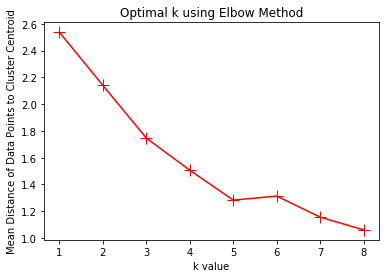

In [59]:
#plot k_mean_distances and k_values
plt.plot(k_values,k_mean_distances, color='red',marker='+',markersize=12)
plt.xlabel('k value')
plt.ylabel('Mean Distance of Data Points to Cluster Centroid')
plt.title('Optimal k using Elbow Method')
plt.show()

We can see on the plot above that the mean distance drops down at the k value 5 and gives the graph elbow shape. Therefore, we can conclude that our optimal value is: **k = 5**

Now, let's run again kmeans algorithm and obtain the final clustering of Paris neighborhoods.

In [60]:
kclusters=5
# run k-means clustering
kmeans = KMeans(init = "k-means++", n_clusters = kclusters, n_init = 12).fit(Paris_clustering)

# check cluster labels generated for each row in the dataframe
kmeans_labels=kmeans.labels_ 
kmeans_cluster_centers=kmeans.cluster_centers_

Let's add **Paris_Neighborhoods** dataframe a new column **Cluster Label** which includes the kmeas labels calcultated by kmeans algorithm for k = 5.

In [61]:
# add clustering labels
Paris_Neighborhoods.insert(5, 'Cluster Label', kmeans_labels)

In [49]:
Paris_Neighborhoods.head() 

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Label,Competitiveness,Population Density,Median Household Income,Unemployment Rate,Preferred Sector Employee Density
0,75004,Hôtel-de-Ville,Arsenal,48.851585,2.364768,4,low,17179.4,31007.0,8.3,37449.417776
1,75004,Hôtel-de-Ville,Saint-Merri,48.858521,2.351667,0,medium,17179.4,31007.0,8.3,37449.417776
2,75004,Hôtel-de-Ville,Notre-Dame,48.852896,2.352775,0,medium,17179.4,31007.0,8.3,37449.417776
3,75004,Hôtel-de-Ville,Saint-Gervais,48.855719,2.358162,4,low,17179.4,31007.0,8.3,37449.417776
4,75005,Panthéon,Jardin-des-Plantes,48.841940,2.356894,1,low,23270.9,33169.0,7.0,20527.888848


Finally, let's visualize the resulting clusters

In [115]:
# define Downtown address
address = 'Paris, France'

# geolocator = Nominatim(user_agent="ny_explorer")
# location = geolocator.geocode(address)
# latitude = location.latitude
# longitude = location.longitude

#load geomjson files of Paris
Paris_Borough_geo=f'arrondissements-paris.json'
Paris_Neigh_geo=f'quartier_paris.json'

# create map
map_neigh = folium.Map(location=[latitude, longitude], zoom_start=12)

#set color scheme and styling for Boroughs
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add borough and neighborhood borders

style_function_borough=lambda x: {
    'color': 'black',
    'weight': 2.5,
    'fillOpacity': 0
}

#set color scheme and styling for Neighborhoods
style_function_nbh=lambda x: {
    'color': 'black',
    'weight': 1,
    'fillOpacity': 0
}

#add boroughs
folium.GeoJson(
    Paris_Borough_geo,
    style_function=style_function_borough,
    name='geojson',
).add_to(map_neigh)

#add neighborhoods
folium.GeoJson(
    Paris_Neigh_geo,
    style_function=style_function_nbh,
    name='geojson',
).add_to(map_neigh)

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(Paris_Neighborhoods['Latitude'], Paris_Neighborhoods['Longitude'], Paris_Neighborhoods['Neighborhood'], Paris_Neighborhoods['Cluster Label']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_neigh)

# display map
map_neigh




<a id="ref5"></a>
# 4. Cluster Paris Neighborhoods

Now, you can examine each cluster and determine mean features of each one in order to give them specific names.

In [96]:
#add Cluster Label column to Paris_onehot dataframe
Paris_onehot.insert(1, 'Cluster Label', kmeans_labels)

In [97]:
Paris_onehot.groupby('Cluster Label').mean()

,Population Density,Median Household Income,Unemployment Rate,Preferred Sector Employee Density,High Competitiveness,Low Competitiveness,Medium Competitiveness
Cluster Label,,,,,,,
0,13938.095833,35124.541667,7.654167,25013.755919,0,1,0
1,30195.060870,24698.608696,10.282609,13704.787627,0,1,0
2,23635.450000,30352.100000,8.650000,17709.195923,1,0,0
3,23908.700000,31912.500000,8.700000,62996.660219,0,1,0
4,24951.329412,30459.000000,8.911765,25742.010363,0,0,1


Based on the results above, we can easily distinguish three types of cluster based on Competitiveness feature (high, low, and medium). Then, based on Unemployment Rate and densities, we classify the other clusters.
Therefore, I choose the following names for the clusters: 
- Cluster 0: Low Competitiveness, Low Population and Preferred Sector Densities
- Cluster 1: Low Competitiveness, High Unemployment Rate
- Cluster 2: High Competitiveness
- Cluster 3: Low Competitiveness, High Population and Preferred Sector Densities
- Cluster 4: Medium Competitiveness

### Cluster 0: Low Competitiveness, Low Population and Preferred Sector Densities

In [98]:
Paris_Neighborhoods.loc[Paris_Neighborhoods['Cluster Label'] == 0]

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Label,Competitiveness,Population Density,Median Household Income,Unemployment Rate,Preferred Sector Employee Density
0,75004,Hôtel-de-Ville,Arsenal,48.851585,2.364768,0,low,17179.4,31007.0,8.3,37449.417776
3,75004,Hôtel-de-Ville,Saint-Gervais,48.855719,2.358162,0,low,17179.4,31007.0,8.3,37449.417776
4,75005,Panthéon,Jardin-des-Plantes,48.841940,2.356894,0,low,23270.9,33169.0,7.0,20527.888848
5,75005,Panthéon,Val-de-Grâce,48.841684,2.343861,0,low,23270.9,33169.0,7.0,20527.888848
6,75005,Panthéon,Saint-Victor,48.847664,2.354093,0,low,23270.9,33169.0,7.0,20527.888848
16,75012,Reuilly,Picpus,48.830359,2.428827,0,low,8670.0,27110.0,8.5,6706.923557
17,75012,Reuilly,Bel-Air,48.837996,2.433178,0,low,8670.0,27110.0,8.5,6706.923557
18,75012,Reuilly,Bercy,48.835209,2.386210,0,low,8670.0,27110.0,8.5,6706.923557
24,75006,Luxembourg,Monnaie,48.854384,2.340035,0,low,19030.7,39063.0,7.0,23140.635425
26,75006,Luxembourg,Saint-Germain-des-Prés,48.855289,2.333657,0,low,19030.7,39063.0,7.0,23140.635425


### Cluster 1: Low Competitiveness, High Unemployment Rate

In [99]:
Paris_Neighborhoods.loc[Paris_Neighborhoods['Cluster Label'] == 1]

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Label,Competitiveness,Population Density,Median Household Income,Unemployment Rate,Preferred Sector Employee Density
9,75010,Entrepôt,Saint-Vincent-de-Paul,48.880735,2.357471,1,low,31810.4,25618.0,9.9,26739.961038
11,75010,Entrepôt,Porte-Saint-Denis,48.873618,2.352283,1,low,31810.4,25618.0,9.9,26739.961038
13,75011,Popincourt,Sainte-Marguerite,48.852097,2.388765,1,low,40059.1,26810.0,9.8,15550.650361
15,75011,Popincourt,Folie-Méricourt,48.867403,2.372965,1,low,40059.1,26810.0,9.8,15550.650361
20,75014,Observatoire,Plaisance,48.830317,2.315305,1,low,24309.4,27288.0,8.9,12210.240086
21,75014,Observatoire,Parc-de-Montsouris,48.823453,2.337070,1,low,24309.4,27288.0,8.9,12210.240086
23,75014,Observatoire,Petit-Montrouge,48.826653,2.326437,1,low,24309.4,27288.0,8.9,12210.240086
32,75013,Gobelins,Maison-Blanche,48.823128,2.352433,1,low,25391.9,23751.0,9.8,14482.933905
33,75013,Gobelins,Croulebarbe,48.833734,2.347673,1,low,25391.9,23751.0,9.8,14482.933905
34,75013,Gobelins,Salpêtrière,48.837406,2.363319,1,low,25391.9,23751.0,9.8,14482.933905


### Cluster 2: High Competitiveness

In [100]:
Paris_Neighborhoods.loc[Paris_Neighborhoods['Cluster Label'] == 2]

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Label,Competitiveness,Population Density,Median Household Income,Unemployment Rate,Preferred Sector Employee Density
7,75005,Panthéon,Sorbonne,48.849045,2.345747,2,high,23270.9,33169.0,7.0,20527.888848
8,75010,Entrepôt,Porte-Saint-Martin,48.871245,2.361504,2,high,31810.4,25618.0,9.9,26739.961038
10,75010,Entrepôt,Hôpital-Saint-Louis,48.876008,2.368123,2,high,31810.4,25618.0,9.9,26739.961038
19,75012,Reuilly,Quinze-Vingts,48.846916,2.374402,2,high,8670.0,27110.0,8.5,6706.923557
35,75013,Gobelins,Gare,48.827527,2.372398,2,high,25391.9,23751.0,9.8,14482.933905
36,75007,Palais-Bourbon,Gros-Caillou,48.858300,2.301542,2,high,12839.1,42466.0,7.1,17380.930578
38,75007,Palais-Bourbon,Saint-Thomas-d'Aquin,48.855263,2.325588,2,high,12839.1,42466.0,7.1,17380.930578
46,75015,Vaugirard,Necker,48.842711,2.310777,2,high,27533.5,30448.0,7.8,15116.549673
55,75003,Temple,Archives,48.859192,2.363205,2,high,29733.3,31333.0,8.7,23319.156574
74,75018,Buttes-Montmartre,Clignancourt,48.891668,2.345979,2,high,32455.9,21542.0,10.7,8696.723447


### Cluster 3: Low Competitiveness, High Population and Preferred Sector Densities

In [105]:
cluster3=Paris_Neighborhoods.loc[Paris_Neighborhoods['Cluster Label'] == 3]
cluster3

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Label,Competitiveness,Population Density,Median Household Income,Unemployment Rate,Preferred Sector Employee Density
49,75002,Bourse,Mail,48.868008,2.344699,3,low,20464.6,30567.0,9.2,67892.595227
50,75002,Bourse,Bonne-Nouvelle,48.867150,2.350080,3,low,20464.6,30567.0,9.2,67892.595227
51,75002,Bourse,Gaillon,48.869307,2.333432,3,low,20464.6,30567.0,9.2,67892.595227
60,75009,Opéra,Rochechouart,48.879812,2.344861,3,low,27352.8,33258.0,8.2,58100.725211
62,75009,Opéra,Chaussée-d'Antin,48.873547,2.332269,3,low,27352.8,33258.0,8.2,58100.725211
63,75009,Opéra,Faubourg-Montmartre,48.873935,2.343253,3,low,27352.8,33258.0,8.2,58100.725211


### Cluster 4: Medium Competitiveness

In [102]:
Paris_Neighborhoods.loc[Paris_Neighborhoods['Cluster Label'] == 4]

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Label,Competitiveness,Population Density,Median Household Income,Unemployment Rate,Preferred Sector Employee Density
1,75004,Hôtel-de-Ville,Saint-Merri,48.858521,2.351667,4,medium,17179.4,31007.0,8.3,37449.417776
2,75004,Hôtel-de-Ville,Notre-Dame,48.852896,2.352775,4,medium,17179.4,31007.0,8.3,37449.417776
12,75011,Popincourt,Roquette,48.857064,2.380364,4,medium,40059.1,26810.0,9.8,15550.650361
14,75011,Popincourt,Saint-Ambroise,48.862345,2.376118,4,medium,40059.1,26810.0,9.8,15550.650361
22,75014,Observatoire,Montparnasse,48.837623,2.331784,4,medium,24309.4,27288.0,8.9,12210.240086
25,75006,Luxembourg,Odéon,48.847801,2.336339,4,medium,19030.7,39063.0,7.0,23140.635425
28,75008,Élysée,Champs-Elysées,48.867074,2.308652,4,medium,9395.1,40540.0,6.9,51185.860048
40,75017,Batignolles-Monceau,Batignolles,48.888482,2.313856,4,medium,29600.5,30282.0,9.2,16278.654797
44,75015,Vaugirard,Saint-Lambert,48.834294,2.296920,4,medium,27533.5,30448.0,7.8,15116.549673
47,75015,Vaugirard,Grenelle,48.850172,2.291853,4,medium,27533.5,30448.0,7.8,15116.549673



<a id="ref6"></a>
# 7. Conclusion

We can notice from the Cluster 3 dataframe that the neighborhoods **Rochechouart, Chaussée-d'Antin, and Faubourg-Montmartre** have the preferred demographic features. Therefore, they are the best candidates to be recommended to a coffee shop starter.

In [119]:
# define Downtown address
address = 'Paris, France'

# geolocator = Nominatim(user_agent="ny_explorer")
# location = geolocator.geocode(address)
# latitude = location.latitude
# longitude = location.longitude

#load geomjson files of Paris
Paris_Borough_geo=f'arrondissements-paris.json'
Paris_Neigh_geo=f'quartier_paris.json'

# create map
map_neigh = folium.Map(location=[latitude, longitude], zoom_start=12)

#set color scheme and styling for Boroughs
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add borough and neighborhood borders

style_function_borough=lambda x: {
    'color': 'black',
    'weight': 2.5,
    'fillOpacity': 0
}

#set color scheme and styling for Neighborhoods
style_function_nbh=lambda x: {
    'color': 'black',
    'weight': 1,
    'fillOpacity': 0
}

#add boroughs
folium.GeoJson(
    Paris_Borough_geo,
    style_function=style_function_borough,
    name='geojson',
).add_to(map_neigh)

#add neighborhoods
folium.GeoJson(
    Paris_Neigh_geo,
    style_function=style_function_nbh,
    name='geojson',
).add_to(map_neigh)

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(cluster3['Latitude'], cluster3['Longitude'], cluster3['Neighborhood'], cluster3['Cluster Label']):
    if poi in ['Rochechouart', 'Chaussée-d\'Antin', 'Faubourg-Montmartre' ]:
        if poi=='Chaussée-d\'Antin':
            poi='Chaussee-d\'Antin'
        label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
        folium.CircleMarker(
            [lat, lon],
            radius=5,
            popup=label,
            color=rainbow[cluster-1],
            fill=True,
            fill_color=rainbow[cluster-1],
            fill_opacity=0.7).add_to(map_neigh)

# display map
map_neigh
